# Use GANs to Create Monet Art

### The purpose of this project is to use GANs to extract features from Monet art images and photos and use these features to generate picttures.

### The dataset contains four kinds of files: __monet_jpg__ (300 Monet paintings sized 256x256 in JPEG format); __monet_tfrec__ (300 Monet paintings sized 256x256 in TFRecord format); __photo_jpg__ (7038 photos sized 256x256 in JPEG format); __photo_tfrec__ (7038 photos sized 256x256 in TFRecord format).

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

gan_getting_started_path = kagglehub.competition_download('gan-getting-started')

print('Data source import complete.')


100%|██████████| 367M/367M [00:18<00:00, 20.7MB/s]

Extracting files...


Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Exploratory data analysis

### I first checked the number of images in each file. Then, I randomly selected some images to present. From the selected images and photos, we can see that there are many landscape paintings.

In [4]:
import tensorflow as tf
import pathlib

# gan_getting_started_path = "/content/gan-getting-started"
data_root = pathlib.Path(gan_getting_started_path)

monet_jpg_path = data_root / "monet_jpg"
photo_jpg_path = data_root / "photo_jpg"

monet_jpg_files = tf.io.gfile.glob(str(monet_jpg_path / "*.jpg"))
photo_jpg_files = tf.io.gfile.glob(str(photo_jpg_path / "*.jpg"))

print("Monet JPG:", len(monet_jpg_files))   # number of images
print("Photo JPG:", len(photo_jpg_files))   # number of images

Monet JPG: 300
Photo JPG: 7038


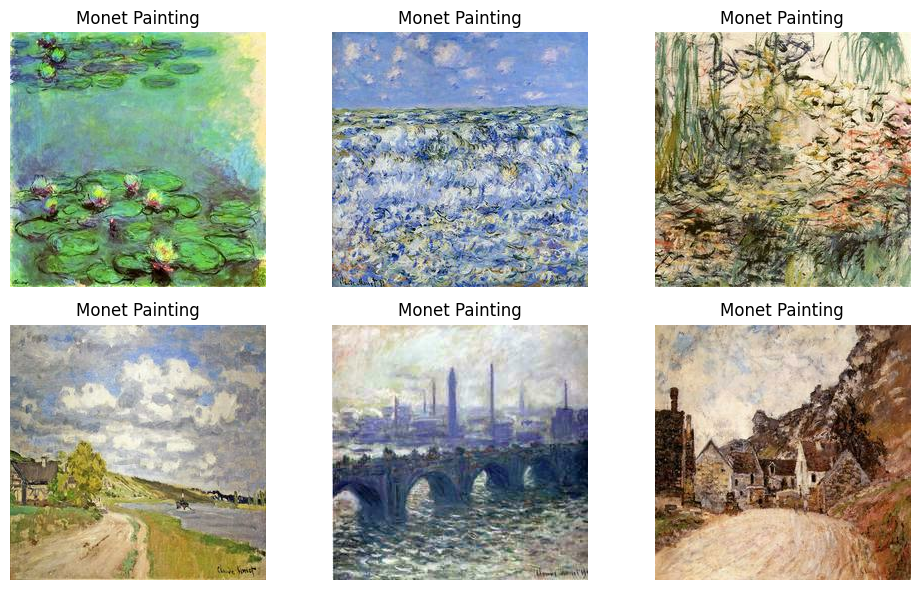

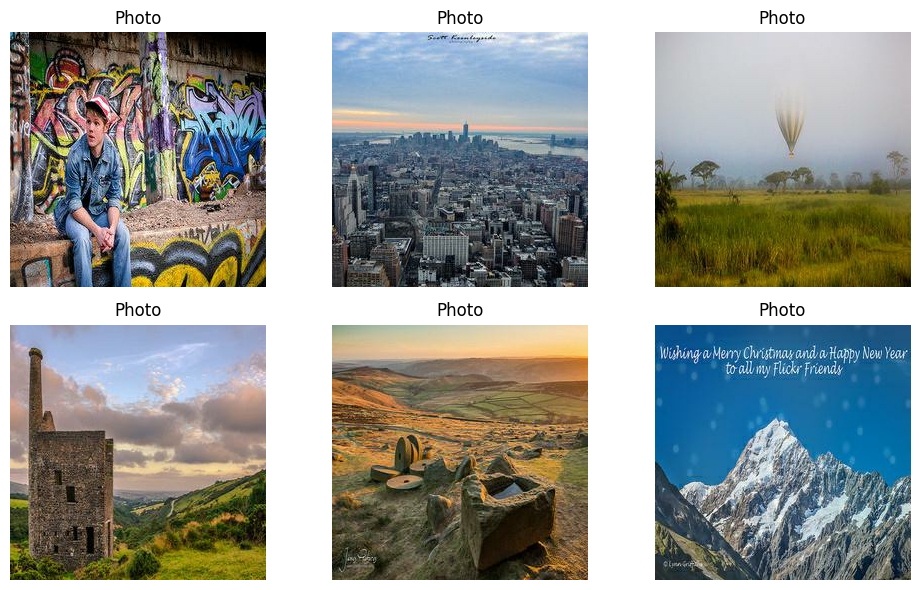

In [5]:
import matplotlib.pyplot as plt
import random

def show_random_images(file_list, title, rows=2, cols=3):
    plt.figure(figsize=(10, 6))
    for i in range(rows * cols):
        img_path = random.choice(file_list)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)

        plt.subplot(rows, cols, i+1)
        plt.imshow(img.numpy())
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show Monet paintings
show_random_images(monet_jpg_files, "Monet Painting")

# Show Photo images
show_random_images(photo_jpg_files, "Photo")

In [6]:
def check_shape(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img.shape

print("Monet image shape:", check_shape(monet_jpg_files[0]))
print("Photo image shape:", check_shape(photo_jpg_files[0]))

Monet image shape: (256, 256, 3)
Photo image shape: (256, 256, 3)


In [7]:
# Image size (downsized for training efficiency)
IMG_HEIGHT = 128
IMG_WIDTH = 128

def load_and_preprocess_image(path):
    """Read a JPG file, decode, resize, and normalize to [-1, 1]."""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)          # RGB
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  # ensure 128x128
    img = tf.cast(img, tf.float32)
    # Normalize to [-1, 1] for DCGAN with tanh output
    img = (img - 127.5) / 127.5
    return img

BUFFER_SIZE = len(monet_jpg_files)
BATCH_SIZE = 16

monet_dataset = (
    tf.data.Dataset.from_tensor_slices(monet_jpg_files)
    .shuffle(BUFFER_SIZE)
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
for batch in monet_dataset.take(1):
    print(batch.shape, batch.dtype, tf.reduce_min(batch).numpy(), tf.reduce_max(batch).numpy())

(16, 128, 128, 3) <dtype: 'float32'> -1.0 1.0


# Model architecture

### For building the GANs model, I first resized images to be 128x128 for training efficiency. Then, I create make_generator_model() to

In [9]:
# the generator starts with some features and resizing them to 128x128 Monet style images
def make_generator_model():
    model = tf.keras.Sequential()

    # Start with a dense layer to project the noise vector
    model.add(layers.Dense(16 * 16 * 512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to 16x16x512
    model.add(layers.Reshape((16, 16, 512)))
    assert model.output_shape == (None, 16, 16, 512)

    # Upsample to 32x32
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 128x128
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final RGB output: 128x128x3
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1),
                                     padding='same', use_bias=False,
                                     activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


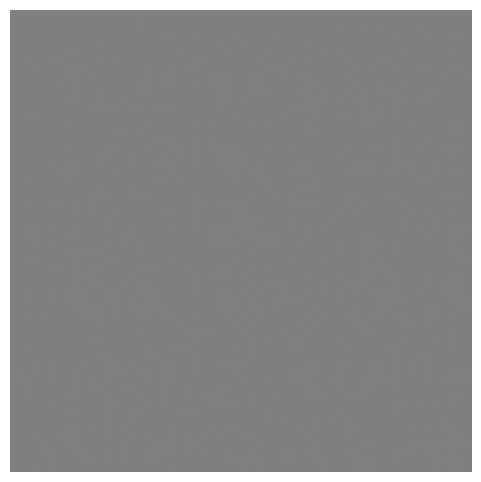

In [10]:
from tensorflow.keras import layers

# Create generator instance
generator = make_generator_model()

# Generate 1 random image from noise
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# Convert from [-1, 1] to [0, 1] for display
img = (generated_image[0] + 1) / 2.0

plt.figure(figsize=(6, 6))
plt.imshow(img.numpy())   # RGB image
plt.axis("off")
plt.show()

In [11]:
# The discriminator shrinks the image down, layer by layer, learning the features that separate real Monet paintings from generated ones.
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Input: 128x128x3
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2),
                            padding='same', input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 128x128 → 64x64x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 64x64 → 32x32x256
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 32x32 → 16x16x512
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and classify
    model.add(layers.Flatten())
    model.add(layers.Dense(1))   # no sigmoid, same as tutorial

    return model

In [12]:
discriminator = make_discriminator_model()

decision = discriminator(generated_image)
print(decision)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[7.790446e-05]], shape=(1, 1), dtype=float32)


In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
import os

checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [22]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

# Reuse the same seed every epoch for consistent visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:
# Compile with tf.function for performance
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    # Convert from [-1,1] → [0,1]
    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis("off")

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()

In [25]:
import time
from IPython import display

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(
            epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [26]:
train(monet_dataset, EPOCHS)

Time for epoch 150 is 4.436950445175171 sec


# Model architecture

### For the parameter tuning, I mainly focused on changes of the epochs. When the epoch is set to 5, there are almost no obvious features. When the epoch is set 10, some colors appear. When the epoch is set to 20, more colors appear. They have some features from landcape paintings from Monet.

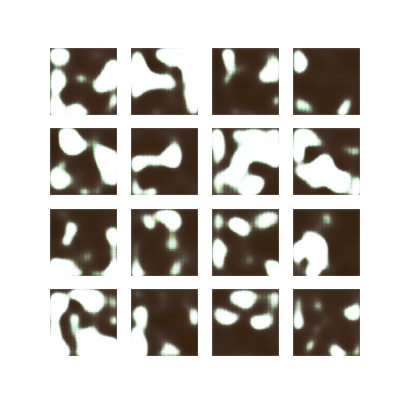

In [27]:
from IPython.display import Image, display

# Show the last generated image grid from training
display(Image(filename='image_at_epoch_0005.png'))

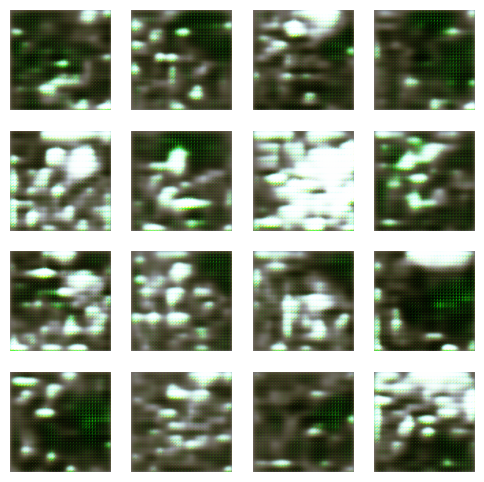

In [28]:
import matplotlib.pyplot as plt
import numpy as np

noise = tf.random.normal([16, noise_dim])
preds = generator(noise, training=False)
preds = (preds + 1) / 2.0  # back to [0,1]

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i])
    plt.axis("off")
plt.show()

In [29]:
import os
os.makedirs("images", exist_ok=True)

In [30]:
import numpy as np
from PIL import Image
from tqdm import tqdm

total_images = 7000          # you can choose 7000–10000
batch_size = 32              # generate in batches
noise_dim = 100              # your generator input dim

for i in tqdm(range(0, total_images, batch_size)):
    # Generate noise
    noise = tf.random.normal([batch_size, noise_dim])

    # Generate 128×128 images
    gen = generator(noise, training=False)
    gen = (gen + 1) / 2.0    # [-1,1] → [0,1]
    gen = gen.numpy()

    for j in range(batch_size):
        img = (gen[j] * 255).astype(np.uint8)         # convert to uint8
        img = Image.fromarray(img)                    # PIL image (128×128)

        # Resize to 256×256
        img = img.resize((256, 256), Image.BICUBIC)

        # Save as JPEG
        img.save(f"images/{i + j}.jpg")

100%|██████████| 219/219 [00:27<00:00,  8.00it/s]


In [31]:
import os, zipfile

img_dir = "images"
zip_path = "images.zip"

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for fname in sorted(os.listdir(img_dir)):
        if fname.lower().endswith(".jpg"):
            z.write(os.path.join(img_dir, fname), arcname=fname)

print("Created:", zip_path)

Created: images.zip


In [32]:
!ls -lh

total 97M
-rw-r--r-- 1 root root 140K Nov 22 22:15 image_at_epoch_0001.png
-rw-r--r-- 1 root root 135K Nov 22 22:15 image_at_epoch_0002.png
-rw-r--r-- 1 root root 135K Nov 22 22:15 image_at_epoch_0003.png
-rw-r--r-- 1 root root 136K Nov 22 22:16 image_at_epoch_0004.png
-rw-r--r-- 1 root root 133K Nov 22 22:16 image_at_epoch_0005.png
-rw-r--r-- 1 root root 147K Nov 22 22:16 image_at_epoch_0006.png
-rw-r--r-- 1 root root 157K Nov 22 22:16 image_at_epoch_0007.png
-rw-r--r-- 1 root root 172K Nov 22 22:16 image_at_epoch_0008.png
-rw-r--r-- 1 root root 162K Nov 22 22:16 image_at_epoch_0009.png
-rw-r--r-- 1 root root 161K Nov 22 22:16 image_at_epoch_0010.png
-rw-r--r-- 1 root root 159K Nov 22 22:16 image_at_epoch_0011.png
-rw-r--r-- 1 root root 163K Nov 22 22:16 image_at_epoch_0012.png
-rw-r--r-- 1 root root 169K Nov 22 22:16 image_at_epoch_0013.png
-rw-r--r-- 1 root root 173K Nov 22 22:16 image_at_epoch_0014.png
-rw-r--r-- 1 root root 176K Nov 22 22:16 image_at_epoch_0015.png
-rw-r--r-- 1 ro

In [33]:
from google.colab import files
files.download("images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Takeaways and learning

### It is important to set the image size. When the image size is 256x256, it can capture more information but the training will take longer.

### It is important to pay attention to epochs. From 5, 10, 20, 50 to 150, I see more noticeable features. I think more epochs will be better. Still need to strike a balance between quality and efficiency

### When dealing with image data, it is better to use GPU or TPU, much faster than CPU.